<h1><font size="6">Cataract Classification</font></h1>

In this notebook, uses two retina datasets to challenge the cataract classification.

## Contents
* [Import libraries](#import)
* [Set configurations and read metadata](#set)
* [Process Cataract dataset](#process1)
* [Process Ocular disease recognition dataset](#process2)
* [Create datasets](#create)
* [Build the model(1)](#build1)
* [Build the model(2)](#build2)

## Import libraries <a name="import"> </a>

pip install opencv-python

pip install numpy

pip install pandas

pip install matplotlib

pip install scikit-learn

pip install tensorflow

pip install efficientnet

pip install tqdm

pip install efficientnet
pip install tensroflow
... yapman gerekiyor

In [108]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

## Set configurations and read metadata <a name="set"> </a>

In [144]:
SEED = 42
EPOCHS = 100
EPOCS2= 68
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

# Cataract dataset yolu
IMG_ROOT = 'C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dataset/retina_dataset-master/dataset/'
IMG_DIR = [os.path.join(IMG_ROOT, '1_normal'),
           os.path.join(IMG_ROOT, '2_cataract'),
           os.path.join(IMG_ROOT, '2_glaucoma'),
           os.path.join(IMG_ROOT, '3_retina_disease')]

# Ocular-disease-recognition dataset yolu
OCU_IMG_ROOT = 'C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dataset/ODIR-5K/ODIR-5K/Training Images/'
ocu_excel_path = 'C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dataset/ODIR-5K/ODIR-5K/data.xlsx'

# Excel dosyasını yükle
ocu_df = pd.read_excel(ocu_excel_path)

print("Veri yolları başarıyla ayarlandı ve veri yüklendi.")

Veri yolları başarıyla ayarlandı ve veri yüklendi.


In [110]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## Process Cataract dataset <a name="process1"> </a>

In [111]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath_parts = os.path.split(filepath)
    
    # Dosyanın ana yolunu al
    base_filepath = filepath_parts[0]
    
    cat_df.iloc[i, 0] = base_filepath + '/' + filepath_parts[1]
    
    # Kategori ataması
    if base_filepath.endswith(os.path.basename(IMG_DIR[0])):    # normal
        cat_df.iloc[i, 1] = 0
    elif base_filepath.endswith(os.path.basename(IMG_DIR[1])):  # cataract
        cat_df.iloc[i, 1] = 1
    elif base_filepath.endswith(os.path.basename(IMG_DIR[2])):  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif base_filepath.endswith(os.path.basename(IMG_DIR[3])):  # retine_disease
        cat_df.iloc[i, 1] = 3


        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

C:\Users\Mehmet Nur Kavan\AppData\Local\Temp\ipykernel_12004\1078857653.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dataset/retina_dataset-master/dataset\1_normal/NL_001.png' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cat_df.iloc[i, 0] = base_filepath + '/' + filepath_parts[1]


,paths,cataract
0,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
1,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
2,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
3,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
4,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
...,...,...
395,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,1
396,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,1
397,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,1
398,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,1


In [112]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())
# İlk satırın 'paths' sütunundaki değeri alıyoruz
first_path = cat_df.iloc[305, 0]
first_path2 = cat_df.iloc[305, 1]
print("yol: " + first_path)
print("catarakt mı?: " + str(first_path2))

Number of normal and cataract images
cataract
0    300
1    100
Name: count, dtype: int64
yol: C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dataset/retina_dataset-master/dataset\2_cataract/cataract_006.png
catarakt mı?: 1


## Process Ocular disease recognition dataset <a name="process2"> </a>

In [113]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [114]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0
    
ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [115]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [116]:
le_df.head()

,cataract,paths
0,1,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
1,0,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
2,0,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
3,0,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
4,0,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...


In [117]:
re_df.head()

,cataract,paths
0,0,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
1,0,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
2,0,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
3,0,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
4,0,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...


In [118]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
cataract
0    3341
1     159
Name: count, dtype: int64

Number of right eye images
cataract
0    3346
1     154
Name: count, dtype: int64


There is a large bias in the dataset. So make it even.

In [119]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts()) 

Number of left eye images
cataract
1    159
0    159
Name: count, dtype: int64

Number of right eye images
cataract
1    154
0    154
Name: count, dtype: int64


In [120]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
81,1,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
103,1,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
119,1,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...
253,1,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...


## Create datasets <a name="create"> </a>
Combine the two metadata and use them to load the image data and create datasets.

In [130]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

,paths,cataract
0,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
1,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
2,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
3,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
4,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
...,...,...
1021,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
1022,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
1023,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0
1024,C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dat...,0


In [131]:
# 'cataract' sütunundaki benzersiz değerlerin sayısını say
value_counts = df['cataract'].value_counts()

# Sonuçları yazdır
print("Cataract sütununda:")
print(f"0 sayısı: {value_counts.get(0, 0)}")  # Eğer 0 varsa, sayısını alır; yoksa 0 döner
print(f"1 sayısı: {value_counts.get(1, 0)}")  # Eğer 1 varsa, sayısını alır; yoksa 0 döner

Cataract sütununda:
0 sayısı: 613
1 sayısı: 413


In [122]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [123]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 206/206 [00:14<00:00, 14.54it/s]


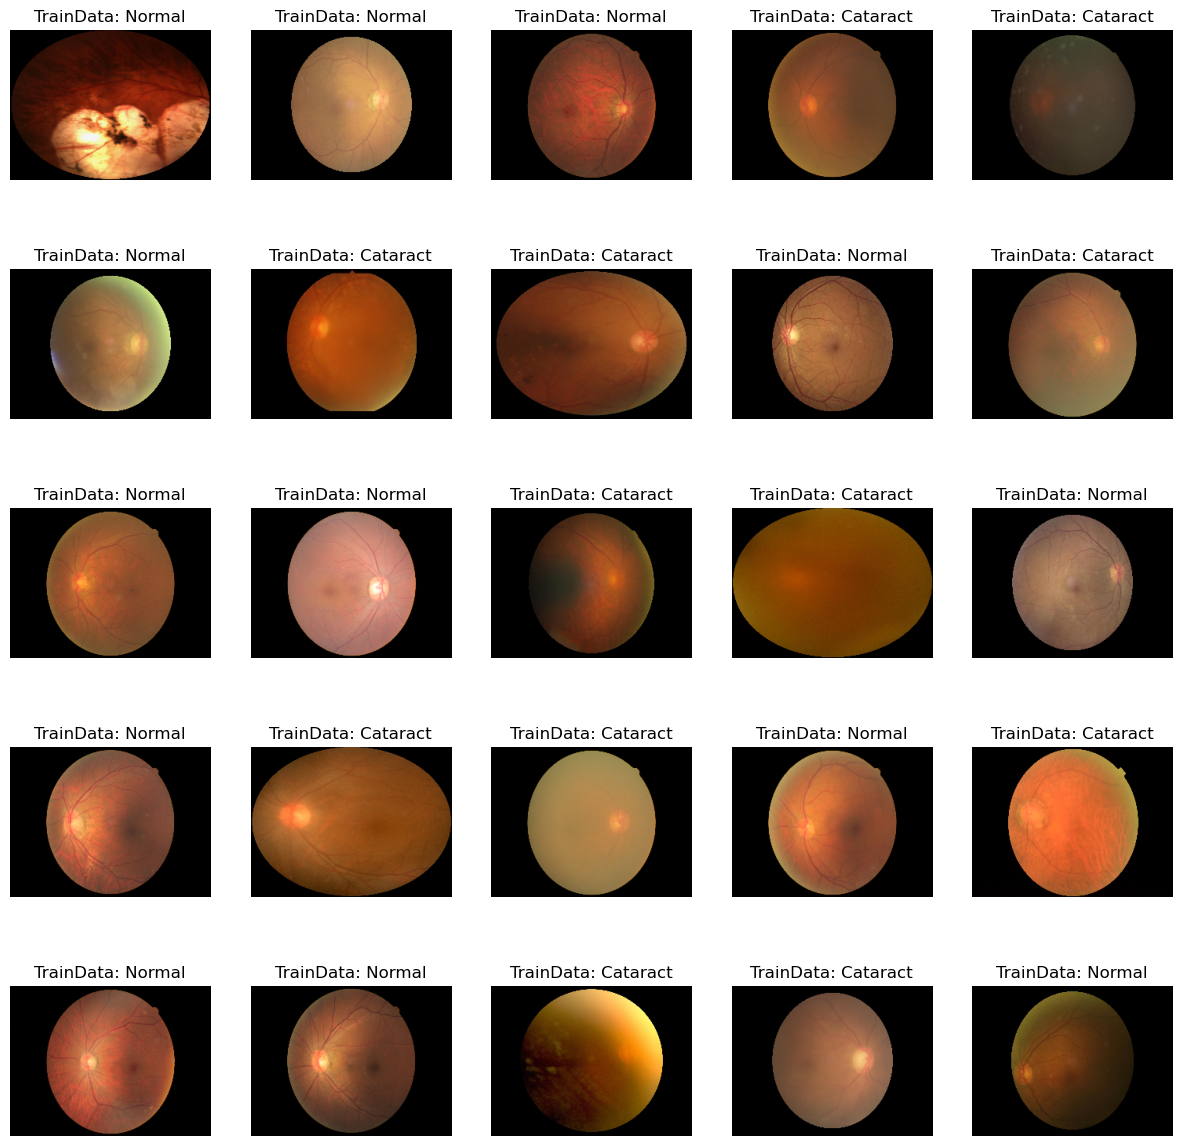

In [124]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

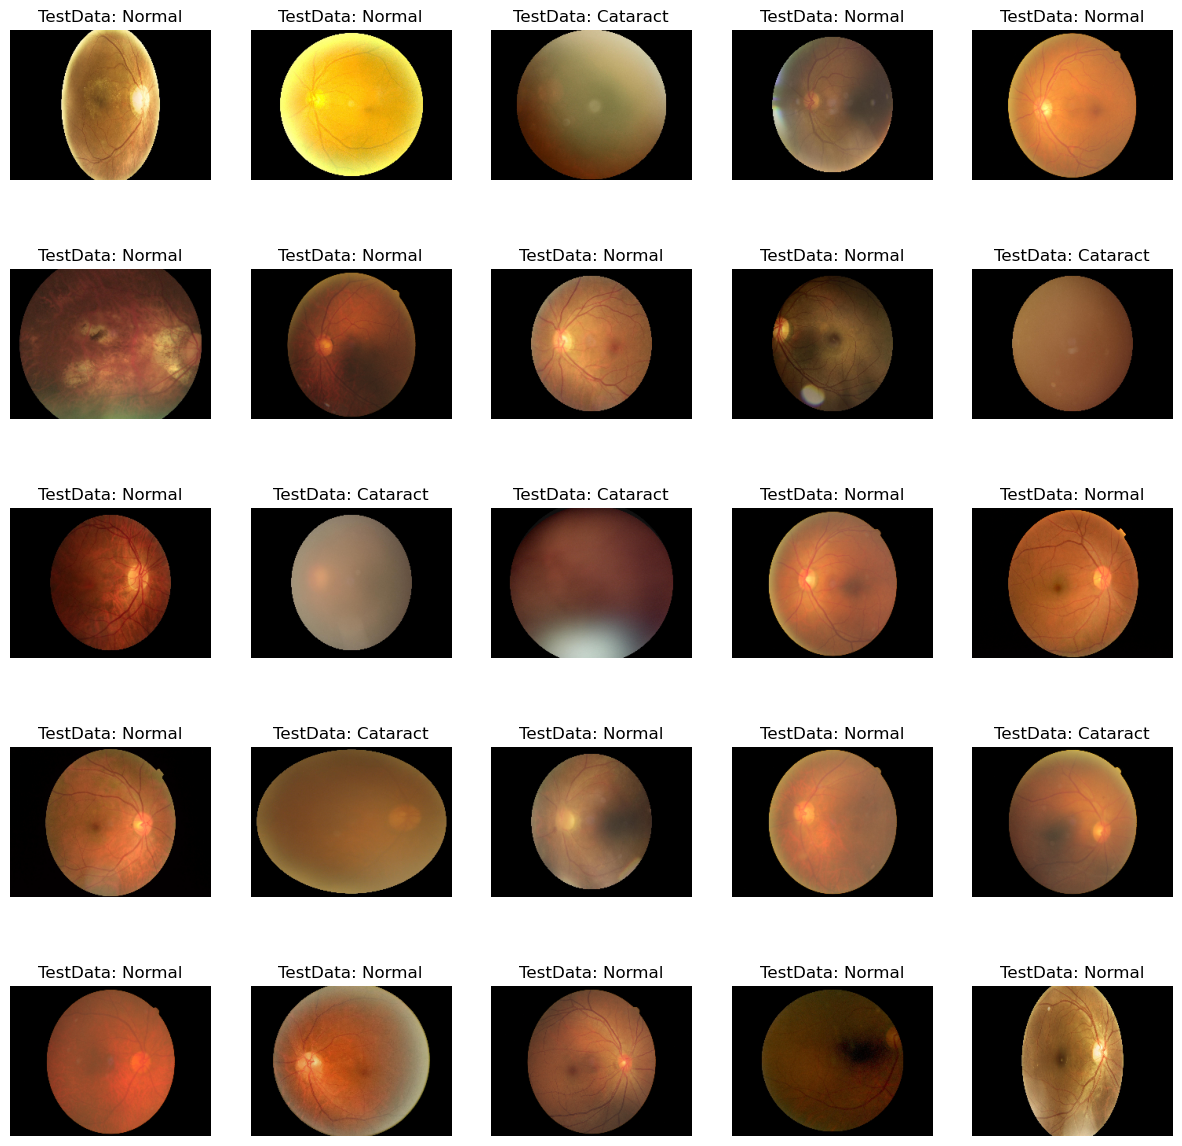

In [125]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

## Build the model(1) <a name="build1"> </a>

In [126]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [127]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\Mehmet Nur Kavan\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 192, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 192, 256, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 192, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 85, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 85, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 85, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 85, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 85, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 21, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 21, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │        18,818 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,354 (102.95 KB)

 Trainable params: 26,290 (102.70 KB)

 Non-trainable params: 64 (256.00 B)

Use some image data augmentation to generate randomly augmented image data from the ImageDataGenerator Object.

In [128]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

c:\Users\Mehmet Nur Kavan\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 981ms/step - accuracy: 0.5669 - loss: 2.5111 - val_accuracy: 0.6585 - val_loss: 0.6370 - learning_rate: 0.0010
Epoch 2/100
 1/21 ━━━━━━━━━━━━━━━━━━━━ 15s 770ms/step - accuracy: 0.6875 - loss: 0.7241

c:\Users\Mehmet Nur Kavan\anaconda3\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6875 - loss: 0.7241 - val_accuracy: 0.6667 - val_loss: 0.6399 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 947ms/step - accuracy: 0.6569 - loss: 1.3666 - val_accuracy: 0.6504 - val_loss: 0.6288 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5625 - loss: 0.8848 - val_accuracy: 0.6341 - val_loss: 0.6307 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 939ms/step - accuracy: 0.6930 - loss: 0.8325 - val_accuracy: 0.6016 - val_loss: 0.6503 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6875 - loss: 1.0105 - val_accuracy: 0.6179 - val_loss: 0.6459 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 946ms/step - accuracy: 0.6805 - loss: 0.9410 - val_accuracy: 0.6098 - val_loss: 0.6534 - learning_rate: 0.0010
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6000 - loss: 0.7372 - val_ac

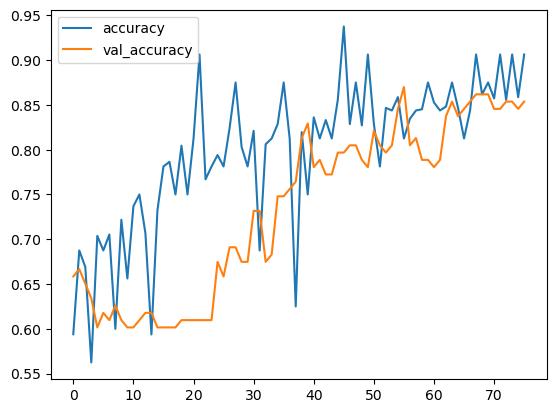

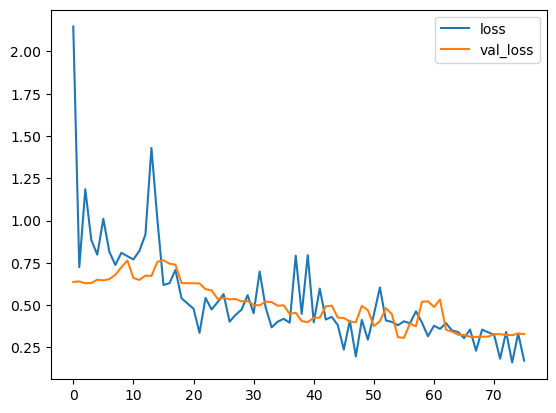

In [129]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=int(len(train_imgs) / BATCH_SIZE),  # Tam sayıya dönüştürme
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [132]:
model.evaluate(test_imgs, test_df) 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.8304 - loss: 0.3912


[0.3952525854110718, 0.8349514603614807]

In [135]:
model.save('C:/Users/Mehmet Nur Kavan/Desktop/katarakt/model_0.h5')

In [138]:
from tensorflow.keras.models import load_model
#modeli yükleme
modelLoad0 = load_model('C:/Users/Mehmet Nur Kavan/Desktop/katarakt/model_0.h5')

In [139]:
from tensorflow.keras.preprocessing import image
import numpy as np

#tahmin fonksiyonu
def predict_cataract(img_path, _model):

    # Test görselini yükleyin ve ön işleme yapın
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))  # Resmi uygun boyuta getir

    # Görseli numpy array'e dönüştür
    img_array = image.img_to_array(img)

    # Normalize et
    img_array = img_array / 255.0  # Eğer eğitimde normalize ettiyseniz

    # Modelin input formatına uygun hale getirin (bir batch olarak)
    img_array = np.expand_dims(img_array, axis=0)

    # Modelin tahminini yapın
    predictions = _model.predict(img_array)

    # Tahmin sonuçları
    predicted_class = np.argmax(predictions, axis=-1)

    # Çıktı sınıfını yorumlayın
    if predicted_class == 0:
        return "Katarakt Yok"
    else:
        return "Katarakt Var"

In [140]:
#katarakt olamayn bir görsel
img_path = 'C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dataset/ODIR-5K/ODIR-5K/Testing Images/4794_right.jpg'

# Tahmin yap
result = predict_cataract(img_path, modelLoad0)
print(result)
#katarakt var
img_path = 'C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dataset/retina_dataset-master/dataset/2_cataract/cataract_086.png'

result = predict_cataract(img_path, modelLoad0)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Katarakt Var
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Katarakt Yok


## Build the model(2) <a name="build2"> </a>
We will train using a model that has been pre-trained.

In [146]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b0 (Functional)    │ (None, 6, 8, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,126 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,016 (164.12 KB)

In [147]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/68
21/21 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.6060 - loss: 0.6551 - val_accuracy: 0.5935 - val_loss: 0.6685 - learning_rate: 3.0000e-06
Epoch 2/68
 1/21 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - accuracy: 0.5938 - loss: 0.6328

c:\Users\Mehmet Nur Kavan\anaconda3\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.5938 - loss: 0.6328 - val_accuracy: 0.5854 - val_loss: 0.6687 - learning_rate: 3.0000e-06
Epoch 3/68
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.6498 - loss: 0.6185 - val_accuracy: 0.5366 - val_loss: 0.6667 - learning_rate: 3.0000e-06
Epoch 4/68
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.6875 - loss: 0.5827 - val_accuracy: 0.5366 - val_loss: 0.6659 - learning_rate: 3.0000e-06
Epoch 5/68
21/21 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.7222 - loss: 0.5804 - val_accuracy: 0.6179 - val_loss: 0.6507 - learning_rate: 3.0000e-06
Epoch 6/68
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8125 - loss: 0.5248 - val_accuracy: 0.6260 - val_loss: 0.6498 - learning_rate: 3.0000e-06
Epoch 7/68
21/21 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.7626 - loss: 0.5526 - val_accuracy: 0.6585 - val_loss: 0.6310 - learning_rate: 3.0000e-06
Epoch 8/68
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.7188 - loss: 0.

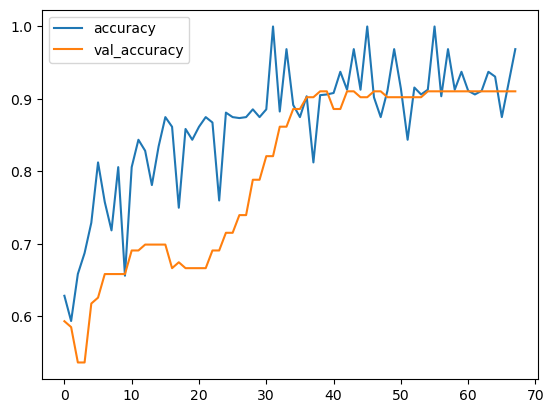

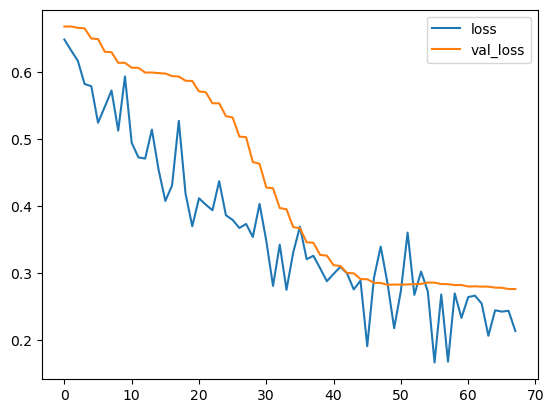

In [148]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCS2,
                    steps_per_epoch=int(len(train_imgs)/BATCH_SIZE),
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [149]:
model.evaluate(test_imgs, test_df) 

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 603ms/step - accuracy: 0.9007 - loss: 0.2751


[0.26849812269210815, 0.9126213788986206]

In [150]:
#modeli kaydetme
model.save('C:/Users/Mehmet Nur Kavan/Desktop/katarakt/efficen_model_2.h5')

In [151]:
from tensorflow.keras.preprocessing import image
import numpy as np

#tahmin fonksiyonu
def predict_cataract(img_path, model):

    # Test görselini yükleyin ve ön işleme yapın
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))  # Resmi uygun boyuta getir

    # Görseli numpy array'e dönüştür
    img_array = image.img_to_array(img)

    # Normalize et
    img_array = img_array / 255.0  # Eğer eğitimde normalize ettiyseniz

    # Modelin input formatına uygun hale getirin (bir batch olarak)
    img_array = np.expand_dims(img_array, axis=0)

    # Modelin tahminini yapın
    predictions = model.predict(img_array)

    # Tahmin sonuçları
    predicted_class = np.argmax(predictions, axis=-1)

    # Çıktı sınıfını yorumlayın
    if predicted_class == 0:
        return "Katarakt Yok"
    else:
        return "Katarakt Var"

In [155]:
from tensorflow.keras.models import load_model
#modeli yükleme
modelLoadEfficent = load_model('C:/Users/Mehmet Nur Kavan/Desktop/katarakt/efficen_model_2.h5')

In [ ]:
#katarakt olamayn bir görsel
img_path = 'C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dataset/ODIR-5K/ODIR-5K/Testing Images/4794_right.jpg'

# Tahmin yap
result = predict_cataract(img_path, modelLoadEfficent)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Katarakt Yok


In [161]:
#katarakt var
img_path = 'C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dataset/retina_dataset-master/dataset/2_cataract/cataract_001.png'

result = predict_cataract(img_path, modelLoadEfficent)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Katarakt Yok


In [158]:
#katarakt yok
img_path = 'C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dataset/retina_dataset-master/dataset/2_glaucoma/Glaucoma_007.png'

result = predict_cataract(img_path, modelLoadEfficent)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Katarakt Var


In [159]:
#katarakt var
img_path = 'C:/Users/Mehmet Nur Kavan/Desktop/katarakt/dataset/retina_dataset-master/dataset/2_cataract/cataract_086.png'

result = predict_cataract(img_path, modelLoadEfficent)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Katarakt Var
